# CS 109A/AC 209A/STAT 121A Data Science: Homework 6
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Wednesday, November 2nd, 2016 at 11:59pm

Download the `IPython` notebook as well as the data file from Vocareum and complete locally.

To submit your assignment, in Vocareum, upload (using the 'Upload' button on your Jupyter Dashboard) your solution to Vocareum as a single notebook with following file name format:

`last_first_CourseNumber_HW6.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 109a, Stats 121a, AC 209a). Submit your assignment in Vocareum using the 'Submit' button.

**Avoid editing your file in Vocareum after uploading. If you need to make a change in a solution. Delete your old solution file from Vocareum and upload a new solution. Click submit only ONCE after verifying that you have uploaded the correct file. The assignment will CLOSE after you click the submit button.**

Problems on homework assignments are equally weighted. The Challenge Question is required for AC 209A students and optional for all others. Student who complete the Challenge Problem as optional extra credit will receive +0.5% towards your final grade for each correct solution. 

Import libraries

In [1]:
import numpy as np
import pandas as pd
import math as m
import scipy as sp
from scipy.stats import mode
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cross_validation import KFold
%matplotlib inline

## Problem 0: Basic Information

Fill in your basic information. 

### Part (a): Your name

Bassily, Hany

### Part (b): Course Number

CS E - 109A

### Part (c): Who did you work with?

None

**All data sets can be found in the ``datasets`` folder and are in comma separated value (CSV) format**

## Problem 1: Recommender System for Movies

In this problem, you will build a model to recommend movies using ratings from users. 

The dataset for this problem is contained in `dataset_4_ratings.txt`. This dataset contains ratings from 100 users for 1000 movies. The first two columns contain the user and movie IDs. The last column contains a 1 if the user liked the movie, and 0 otherwise. Not every movie is rated by every user (i.e. some movies have more ratings than others).

The names of the movies corresponding to the IDs are provided in `dataset_4_movie_names.txt`.

### Part 1(a): Exploring how to rank

One way of recommending movies is to recommend movies that are generally agreed upon to be good. But how do we measure the "goodness" or "likability" of a movie?


- **Implementation:** Suppose we measure the "goodness" of a movie by the probability that it will be liked by a user, $P(\textbf{label} = \text{like}|\textbf{movie}) = \theta_{\text{movie}}$. Assuming that each user independently rates a given movie according to the probability $\theta_{\text{movies}}$. Use a reasonable estimate of $\theta_{\text{movies}}$ to build a list of top 25 movies that you would recommend to a new user.

   **Hint:** What does the likelihood function, $P(\textbf{likes} = k | \theta_{\text{movie}}, n, \textbf{movie})$, look like? What $\theta_{\text{movie}}$ will maximize the likelihood?
   

- **Analysis:** Why is using $\theta_{\text{movie}}$ to rank movies more appropriate than using the total number of likes? Explain why your estimate of $\theta_{\text{movie}}$ is reasonable. Explain the potential draw backs of estimating $\theta_{\text{movie}}$ this way.

   **Hint:** Under what conditions may models that maximize the likelihood be suboptimal? Do those conditions apply here?   

<font color= 'blue'>
### Solution:
</font>
<br>

The solution for this part will proceed as following steps:
 - Open the data file and do a preliminary exploration
 - Suggest a simple classification method and execute it
 - Suggest a more accurate classification method and derive the maximum likelihood probability
 - Apply the suggested method
 - Discuss the results and the potemtial advantages/disadventages
 
All codes used in this section are based on the code authored by Prof. Weiwei Pan

#### 1. Open Data Files and Explore them:

<br>

In [2]:
# Open data files and explore data
# --------------------------------

# Open the movie names file
names_df = pd.read_csv('datasets/dataset_4_movie_names.txt' , delimiter = '|')
names_df.head()

,movie_id,movie_name,release_date,Unnamed: 3,link,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,NaN
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,NaN
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,NaN
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,NaN


In [3]:
# Open the ratings file
ratings_df = pd.read_csv('datasets/dataset_4_ratings.txt' , delimiter = ',')
ratings_df.head()

,user_id,movie_id,rating
0,22.0,377.0,0.0
1,62.0,257.0,0.0
2,95.0,546.0,0.0
3,38.0,95.0,1.0
4,63.0,277.0,1.0


In [4]:
# Function to extract the total number of reviews and the number of likes for each movie:
# ---------------------------------------------------------------------------------------

def movie_stats(movie_name=None, movie_name_contains=None):
    
    #If given an exact movie name:
    if movie_name is not None:        
        
        #Find the index of the movie, by name, in the "names" dataframe
        movie_index = names_df[names_df['movie_name'] == movie_name].index[0]
        
        #Get the id for the movie in the "names" dataframe
        movie_id = names_df.loc[movie_index, 'movie_id']
        
        #Get all ratings for the movie, by id, in the "ratings" dataframe
        ratings_for_movie = ratings_df[ratings_df['movie_id'] == movie_id]
        
        #Count the total number of ratings
        total_ratings = len(ratings_for_movie)
        
        #Count the likes (the 1's)
        likes = ratings_for_movie['rating'].sum()
    
    #Otherwise, if given a partial movie name:
    elif movie_name_contains is not None:
        
        #Find the index of the movie, by name, in the "names" dataframe
        movie_index = names_df[names_df['movie_name'].str.contains(movie_name_contains)].index[0]
        
        #Get the id for the movie in the "names" dataframe
        movie_id = names_df.loc[movie_index, 'movie_id']
        
        #Get all ratings for the movie, by id, in the "ratings" dataframe
        ratings_for_movie = ratings_df[ratings_df['movie_id'] == movie_id]
        
        #Count the total number of ratings
        total_ratings = len(ratings_for_movie)
        
        #Count the likes (the 1's)
        likes = ratings_for_movie['rating'].sum()
    
    else:
        total_ratings = 0.
        likes = 0.
    
    return float(total_ratings), likes

#### 2. Simple Classification Method:

<br>
In this section we will:
 - Get the stats of all the movies
 - implement a simple classification method based on the total number of likes
 
<br>

In [5]:
# Extract an array of the movie names and id:
# ------------------------------------------

# Extract the array
names_unique = names_df['movie_name'].unique()

# get the dimension
n = names_unique.shape[0]

## Get the movie id
id_list = []

# id array
id_df = names_df['movie_id']

id_list = []

for name in names_unique:
    id_list.append (id_df[names_df['movie_name'] == name].values[0])

#id_array
id_unique = np.array(id_list)
    
print '\n Total number of movies is :  ' , n
print '\n'


 Total number of movies is :   992




In [6]:
# Apply the stats functions to the list of movies:
# ------------------------------------------------

# Initiate the stats array
stats_values = np.zeros(( names_unique.shape[0] , 2 ))

# Calculate the stats for the unique names
for i, name in enumerate(names_unique):
    stats_values[i, 0] , stats_values[i, 1] = movie_stats(name)

In [7]:
# Apply the simple classifier based on total number of likes):
# -----------------------------------------------------------

# Get the sort index
rank_ind = np.argsort(stats_values[:,1])[::-1]

# ranked names
ranked_names = names_unique[rank_ind]

# ranked_stats
ranked_stats = stats_values[rank_ind]

# ranking array
ranked_array = np.concatenate((ranked_names.reshape(n , 1) , ranked_stats) , axis = 1)

# Data Frame
ranking_simple = pd.DataFrame(ranked_array , columns = ['names' , 'total_reviews' , 'total_likes'])

# Print the first 25 Movies
ranking_simple.head(25)

,names,total_reviews,total_likes
0,Star Wars (1977),67,58
1,Fargo (1996),58,51
2,Raiders of the Lost Ark (1981),49,47
3,Return of the Jedi (1983),54,46
4,Twelve Monkeys (1995),57,44
5,"Silence of the Lambs, The (1991)",47,42
6,"Shawshank Redemption, The (1994)",39,39
7,Pulp Fiction (1994),46,39
8,Contact (1997),52,38
9,"Fugitive, The (1993)",46,38


#### 3. Probability and likelihood derivation:

<br>

based on the fact that the variable is discrete and the outcome for each individual is only bounded by two states either like or dislike, the binomial distribution will be convenient. Yhe likelihood of the observations based on the binomial distribution will be

$$
p(likes = k|\theta , likes =  n) = \binom{k}{n}\theta^k(1 - \theta)^{n-k}
$$

It is required to choose  a theta that maximizes this likelihood
by applying the log pn both sides, the RHS will be:

$$
log\binom{n}{k} + k.log\theta + (n-k)log(1-\theta)
$$

Taking derivative and equating to zero for maximum likelihood:

$$
0 = \frac{k}{\theta} - \frac{n-k}{1 - \theta}
$$

which simplifies to 

$$
\theta_{best} = \frac{k_{likes}}{n_{ratings}}
$$


#### 4. Apply the suggested probabilty

<br>

In [8]:
# Calculate the probability and Apply it:
# --------------------------------------

# Calculate the probability
prob_like = stats_values[:,1]/stats_values[:,0]


# rank the probabilities
ind_prob = np.argsort(prob_like)[::-1]

# ranked_names
prob_names = names_unique[ind_prob].reshape(n , 1)

# ranked stats
stats_ranked = stats_values[ind_prob] 

# ranked probabilities
prob_ranked = prob_like[ind_prob].reshape(n , 1)

# ranked id
prob_id = id_unique[ind_prob].reshape(n , 1)

# add id to names
names_ext = np.concatenate((prob_id , prob_names) , axis = 1)

# construct array
prob_array = np.concatenate((names_ext, np.concatenate((stats_ranked ,prob_ranked), axis = 1)), axis = 1)


# Data Frame
ranked_prob = pd.DataFrame(prob_array , columns = ['movie_id' , 'movie_name' , 'total_revue', 
                                                   'total_likes' , 'ranking_prob'])

# Print the first 25 movies
ranked_prob.head(25)

,movie_id,movie_name,total_revue,total_likes,ranking_prob
0,360,Wonderland (1997),2,2,1
1,753,Burnt By the Sun (1994),3,3,1
2,528,"Killing Fields, The (1984)",14,14,1
3,533,"Daytrippers, The (1996)",1,1,1
4,534,Traveller (1997),1,1,1
5,224,Ridicule (1996),5,5,1
6,536,Ponette (1996),1,1,1
7,555,White Man's Burden (1995),1,1,1
8,574,Boxing Helena (1993),1,1,1
9,579,Fatal Instinct (1993),1,1,1


#### 5. Discussion:

<br>
 - The total number of likes approach although it is intuitive, it lacks an important information which is how many people did the review
 - The probablity theta as a ratio represents a more normalized meaasure of the number of reviews that liked the movie
 - However, somehow it can be misleeading if the total number of reviews is not big enough in a way that the final outcome could include a substantial amount of bias
 - If the total number of reviews is very small (1 or 2) the probability ratio is useless and cannot stand by itself as a valid criteria for the classification
 - Also the fact that it depends only on the probability ratio without encoding any prior information could generate a preference that does not reflect the true likability of the movie
 - The last statement is obvious in the analysis above where many movies got the same probability ratio while in fact they differ based on other non considered factors
 
 
<br>

### Part 1(b): Exploring the effect of prior beliefs

Let's add a prior, $p(\theta_{\text{movie}})$, to our probabilistic model for movie rating. To keep things simple, we will restrict ourselves to using beta priors.

- **Analysis:** How might adding a prior to our model benifit us in our specific task? Why are beta distributions appropriate priors for our application?

  **Hint:** Try visualizing beta priors $a = b = 1$, $a = b = 0.5$, $a = b = 2$ and $a = 4, b = 2$, for example, what kind of plain-English prior beliefs about the movie does each beta pdf encode?


- **Implementation/Analysis:** How does the choice of prior affect the posterior distribution of the 'likability' for the movies: *Toy Story, Star Wars, The Shawshank Redemption, Down Periscope and Chain Reaction*.

   **Hint:** Use our posterior sampling function to visualize the posterior distribution.
   
 
- **Implementation/Analysis:** How does the effect of the prior on the posterior distribution vary with the number of user ratings? 

   **Hint:** Visualize the posterior distribution for different sizes of subsample of user ratings for the movie *Star Wars*.
   
In the following, we've provide you a couple of functions for visualize beta priors and approximating their associated posteriors.

In [9]:
#--------  plot_beta_prior
# A function to visualize a beta pdf on a set of axes
# Input: 
#      a (parameter controlling shape of beta prior)
#      b (parameter controlling shape of beta prior)
#      color (color of beta pdf)
#      ax (axes on which to plot pdf)
# Returns: 
#      ax (axes with plot of beta pdf)

def plot_beta_prior(a, b, color, ax):
    rv = sp.stats.beta(a, b)
    x = np.linspace(0, 1, 100)
    ax.plot(x, rv.pdf(x), '-', lw=2, color=color, label='a=' + str(a) + ', b=' + str(b))
    ax.set_title('Beta prior with a=' + str(a) + ', b=' + str(b))
    ax.legend(loc='best')
    return ax

In [10]:
#--------  sample_posterior
# A function that samples points from the posterior over a movie's 
# likability, given a binomial likelihood function and beta prior
# Input: 
#      a (parameter controlling shape of beta prior)
#      b (parameter controlling shape of beta prior)
#      likes (the number of likes in likelihood)
#      ratings (total number of ratings in likelihood)
#      n_samples (number of samples to take from posterior)
# Returns: 
#      post_samples (a array of points from the posterior)

def sample_posterior(a, b, likes, ratings, n_samples):
    post_samples = np.random.beta(a + likes, b + ratings - likes, n_samples)
    return post_samples

<font color = 'blue'>
### Solution:

</font>
<br>


#### 1. Visualizing the prior distribution:

<br>

In [11]:
#--------  find_mode
# A function that approximates the mode of a distribution given a sample from the distribution
# Input: 
#      values (samples from the distribution)
#      num_bins (number of bins to use in approximating histogram)
# Returns: 
#      mode (the approximate mode of the distribution)

def find_mode(values, num_bins):
    
    #Make an approximation (histogram) of the distribution using the samples
    bins, edges = np.histogram(values, bins=num_bins)
    #Find the bin in the histogram with the max height
    max_height_index = np.argmax(bins)
    #Find the sample corresponding to the bin with the max height (the mode)
    mode = (edges[max_height_index] + edges[max_height_index + 1]) / 2.
    
    return mode

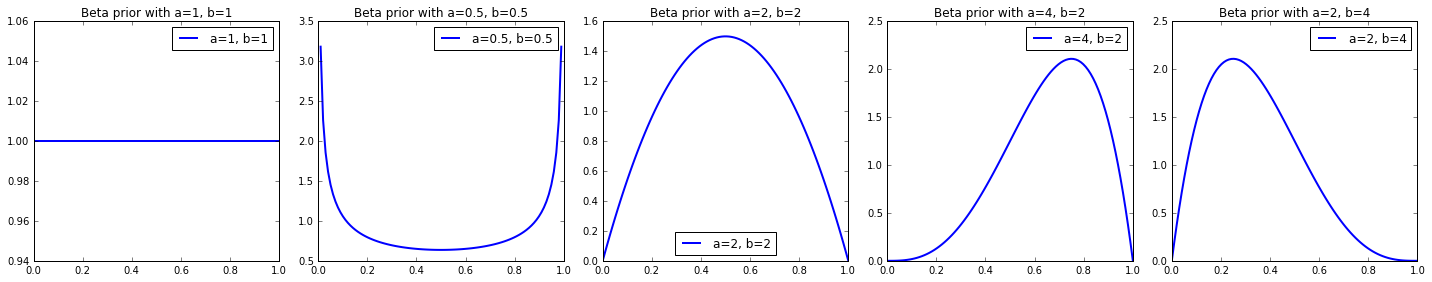

In [12]:
# Construct an array of possible values of the parameters and visualize it
# ------------------------------------------------------------------------

#A list of beta distribution shapes to try out
beta_shapes = [(1, 1), (0.5, 0.5), (2, 2), (4, 2), (2, 4)]

#Length of the list of shapes
n = len(beta_shapes)

#Plot all the beta pdfs in a row
fig, ax = plt.subplots(1, n, figsize=(20, 4))

#Start the index of the current subplot at 0
ax_ind = 0

#Iterate through all the shapes
for a, b in beta_shapes:
   
    #Plot the beta pdf for a particular shape
    plot_beta_prior(a, b, 'blue', ax[ax_ind])
    
    #Increment the subplot index
    ax_ind += 1
    
plt.tight_layout()    
plt.show() 

**Discussion:**

 - The beta distribution domain is between 0 and 1 which is very suitable for the current case as what is needed is a distribution that spans the binary state "like" (1) and "dislike" (0)
 - For the case where a = b = 1, the prior illustrated is a uniform distribution which implies that there is no preference for any selection. Applying this prior will have no affect on the selection probablity and the posterior will be the same as the prior. This is typically used when there is no valid prior to be encoded in the movie selection criteria
 - For the case when a = b = 0.5, the prior will have a polarizing effect which means it will always try to push the selection towards either ends or in other words towards totally like or totally dislike. It will not favor any middle rating. This case is suitable when the prior includes information that their is compromise about the movie quality and most opinions were either strongly liked the movie or strongly disliked it
 - For the third case where a = b = 2, ithas exactly the opposite effect from the previous case where it tries to balance between both extremes
 - The last two cases also try to introduce some balance however they are doing it with a certain bias or favor towards one end or the other. It is more suitable when there is a prior belief that indictes that the movie should be realy tending to be liked or tending to be disliked based on critiques reviews or other sites review

#### 2. Effect of prior selection

<br>

In [13]:
# Function to perform the analysis for every movie name:
# ------------------------------------------------------

def post_analysis (name , a , b , samples):
    
    # Get the likes and the rating
    ratings , likes = movie_stats(name)
    
    # Sample posterior
    return sample_posterior( a, b ,likes ,ratings ,samples)


Toy Story: 0.745098039216 (38.0/51.0)



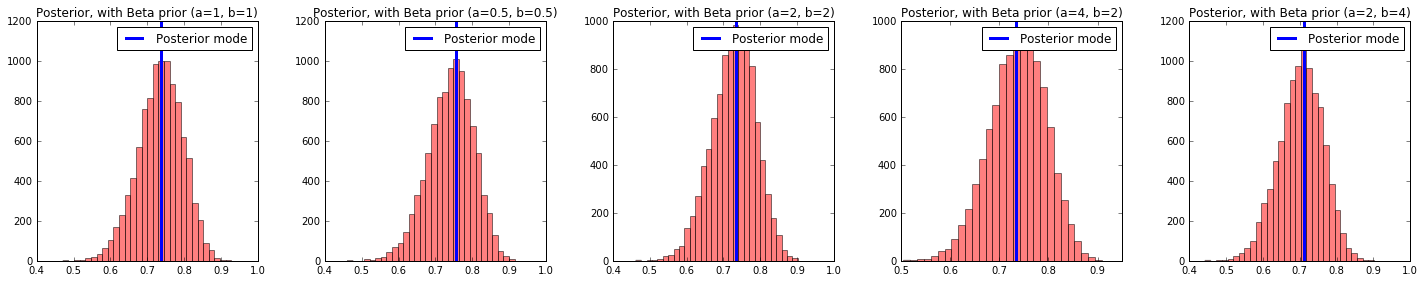


Star Wars: 0.865671641791 (58.0/67.0)



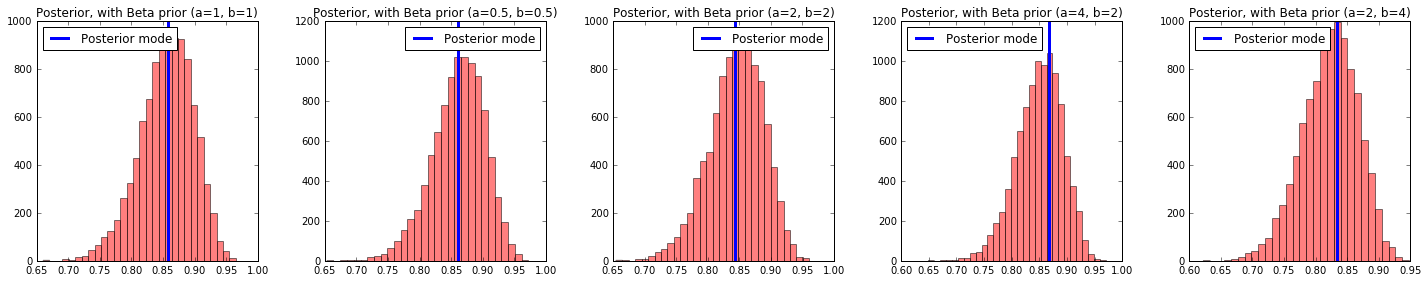


Shawshank Redemption: 1.0 (39.0/39.0)



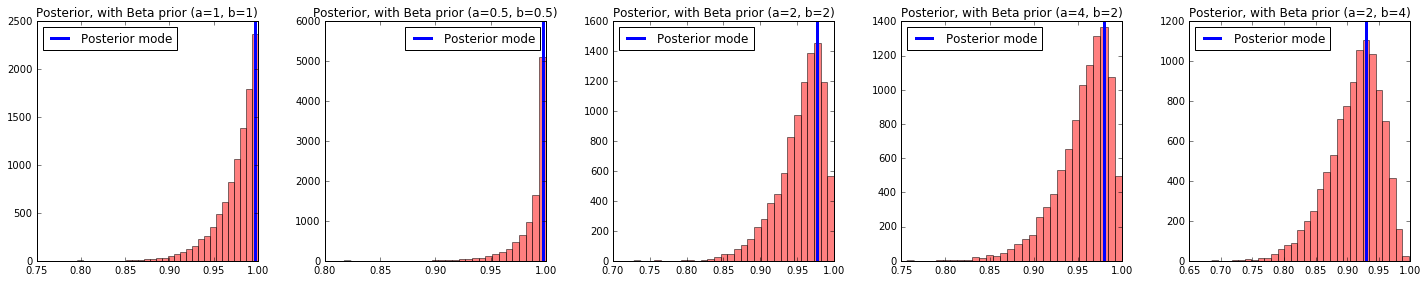


Down Periscope: 0.0666666666667 (1.0/15.0)



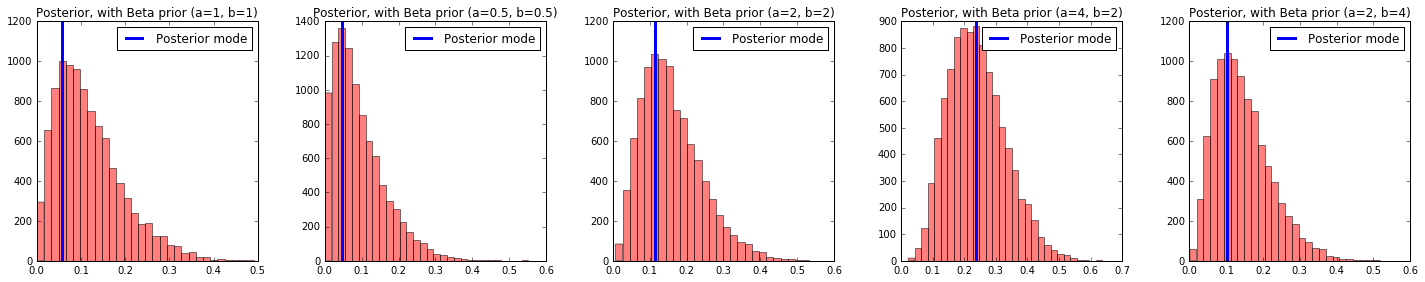


Chain Reaction: 0.0 (0.0/10.0)



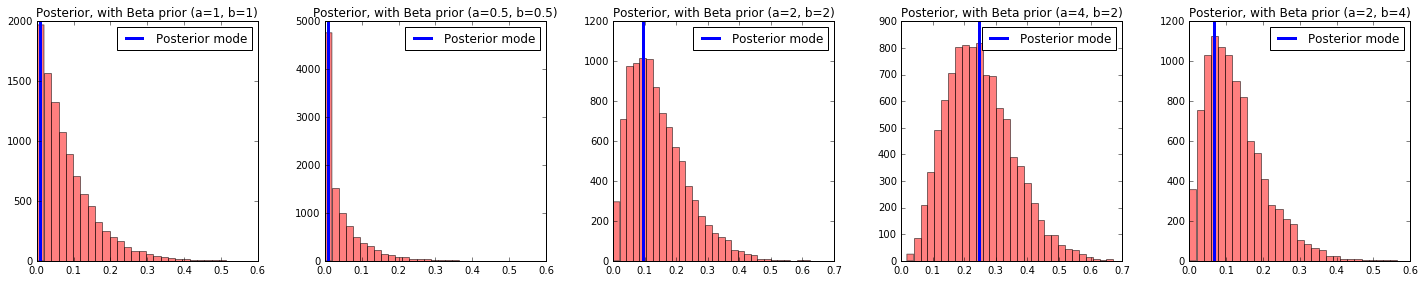

In [14]:
# Calculation of Posteriors:
# --------------------------

# Name list
name_list = ['Toy Story' , 'Star Wars' , 'Shawshank Redemption' , 
             'Down Periscope' , 'Chain Reaction']

# lengrh of the name list
name_len = len(name_list)

# calculate for each movie in the list
for name in name_list:
   
    # Movie info
    info = ranked_prob[ranked_prob['movie_name'].str.contains(name)].values
    
    # parameters
    likes = info[0,3]
    ratings = info[0,2]
    likability = info[0,4]
    
    #Number of samples to use when approximating our posterior
    n_samples = 10000

    #Plot the posterior corresponding to each prior
    fig, ax = plt.subplots(1, n, figsize=(20, 4))

    #Start the index of the current subplot at 0
    ax_ind = 0

    #Iterate through all the shapes
    for a, b in beta_shapes:   
        
        #Draw samples from the posterior corresponding to a particular beta prior
        post_samples = sample_posterior(a, b, likes, ratings, n_samples)
        
        #Approximate the posterior with a histogram of these samples
        ax[ax_ind].hist(post_samples, bins=30, color='red', alpha=0.5)
        
        #Find the approximate mode of the posterior
        mode = find_mode(post_samples, 30)
        
        #Plot the mode as a vertical line
        ax[ax_ind].axvline(x=mode, linewidth=3, label='Posterior mode')
    
        #Set title, legends etc
        ax[ax_ind].set_title('Posterior, with Beta prior (a={}, b={})'.format(a, b))
        ax[ax_ind].legend(loc='best')
       
        #Increment the subplot index
        ax_ind += 1

    # Print Movie Info
    print '\n{}: {} ({}/{})\n'.format(name, likability, likes, ratings)
    
    plt.tight_layout()
    plt.show() 

**Discussion:**

 - The effect of the prior on the posterior is a factor of two things: the prior shape and the total sample size
 - For big sample size, the effect is very minimal, however, the general cojencture about the effect of the prior is still visible in the posterior. In other words, we can observe some shifts in the posteriror probability when compare to the original in the direction that was expected to happen
 - The effect of the prior on the posterior for the small sample size is much more evident than for the big sample size which highlight the importance of the prior in cases where not enough samples are available

#### 3. Effect of the number of user ratings

<br>
for this analysis we will select the following cases:
 - sample of 67 ratings with 58 likes
 - sample of 2 ratings with zero likes
 - sample of 2 ratings with 2 likes
 - sample of 40 ratings with 21 like
 - sample of 40 ratings with 40 likes

In [15]:
# Construct the arrays:
# ---------------------

# ratings array
ratings_array = np.array([67.0 , 2.0 , 2.0 , 40.0 , 40.0])

# likes array
likes_array = np.array([58.0 , 0.0 , 2.0, 21.0 , 40.0])


 case 1: p = 0.865671641791 (58.0/67.0)



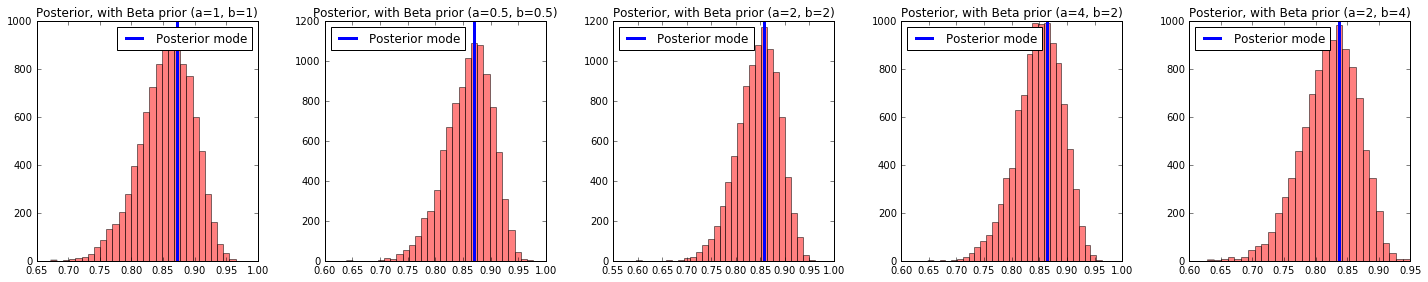


 case 2: p = 0.0 (0.0/2.0)



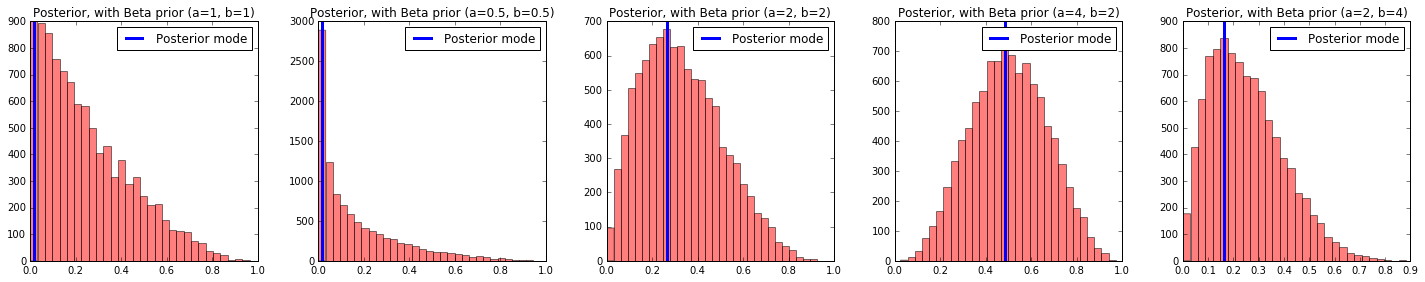


 case 3: p = 1.0 (2.0/2.0)



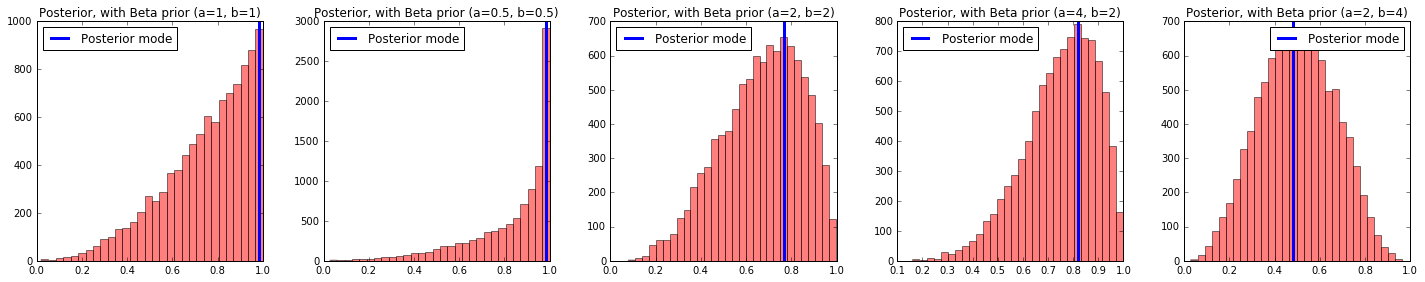


 case 4: p = 0.525 (21.0/40.0)



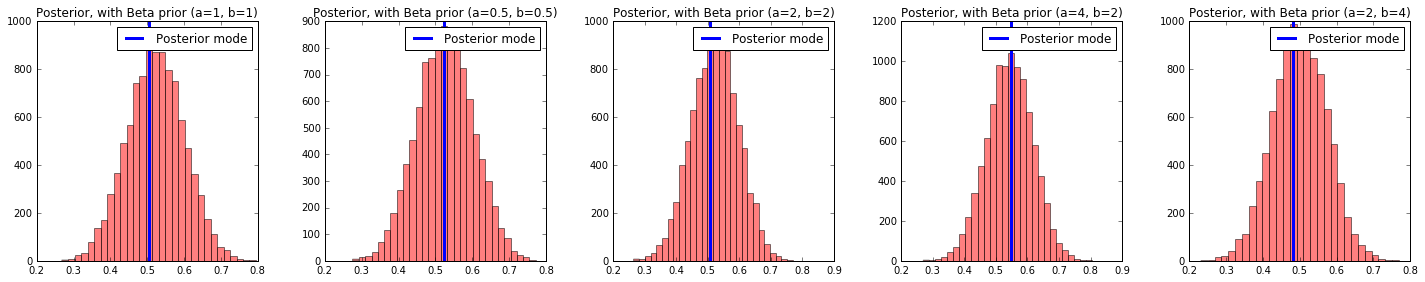


 case 5: p = 1.0 (40.0/40.0)



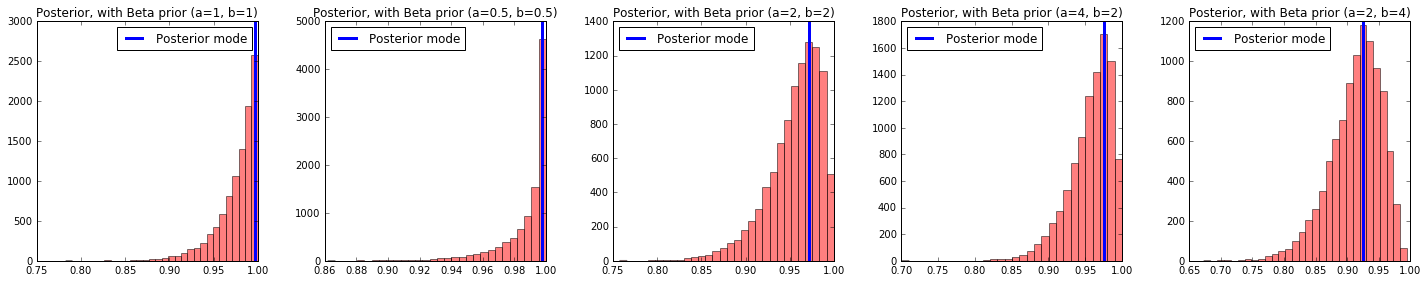

In [16]:
# Conduct the analysis:
# ---------------------

for i in range(len(likes_array)):
    
    # parameters
    likes = likes_array[i]
    ratings = ratings_array[i]
    likability = likes / ratings
    
    #Number of samples to use when approximating our posterior
    n_samples = 10000

    #Plot the posterior corresponding to each prior
    fig, ax = plt.subplots(1, n, figsize=(20, 4))

    #Start the index of the current subplot at 0
    ax_ind = 0

    #Iterate through all the shapes
    for a, b in beta_shapes:   
        
        #Draw samples from the posterior corresponding to a particular beta prior
        post_samples = sample_posterior(a, b, likes, ratings, n_samples)
        
        #Approximate the posterior with a histogram of these samples
        ax[ax_ind].hist(post_samples, bins=30, color='red', alpha=0.5)
        
        #Find the approximate mode of the posterior
        mode = find_mode(post_samples, 30)
        
        #Plot the mode as a vertical line
        ax[ax_ind].axvline(x=mode, linewidth=3, label='Posterior mode')
    
        #Set title, legends etc
        ax[ax_ind].set_title('Posterior, with Beta prior (a={}, b={})'.format(a, b))
        ax[ax_ind].legend(loc='best')
       
        #Increment the subplot index
        ax_ind += 1

    # Print Movie Info
    print '\n case {}: p = {} ({}/{})\n'.format(i+1, likability, likes, ratings)
    
    plt.tight_layout()
    plt.show() 

**Discussion:**

- In general, the prior tends to ease out extreme conditions when the probability is very close to the extremes
- However, the impact is depending on the sample size. The impact of the prior on small sample size in the posteriors is bigger than the impact of the same prior on a big sample size
- Another effect also can be noted which is the prior shape. Except for the polarizing prior, in general the priors try to move the posterior mode towords its own mode. However, this effect is also conditional on the sample size. In other words, the smaller the sample size is the more the posterior mode occurs

### Part 1(c): Recommendation based on ranking

- **Implementation:** Choose a reasonable beta prior, choose a reasonable statistic to compute from the posterior, and then build a list of top 25 movies that you would recommend to a new user based on your chosen posterior statistic.  

 
- **Analysis:** How does your top 25 movies compare with the list you obtained in part(a)? Which method of ranking is better?

 
- **Analysis:** So far, our estimates of the 'likability' for a movie was based on the ratings provided by all users. What can be the draw back of this method? How can we improve the recommender system for individual users (if you feel up to the challenge, implement your improved system and compare it to the one you built in the above)? 

<font color= 'blue'>
### Solution:
</font>
<br>


#### 1. Apply the prior


<br>
For this task a value of a = 2 and b = 4 will be selected for the prior since it has a balancing effect on the extreme cases

<br>

In [17]:
# Calculating the posterior:
# --------------------------

# Extracting the likes, ratings, and likabilities of the movies
data_movie = ranked_prob.iloc[:,2:].values

# prior parameters
a = 2
b = 4

# initiate posteriros
post = np.zeros((data_movie.shape[0],))

for i in range(data_movie.shape[0]):
    
    # extract parameters:
    ratings = data_movie[i,0]
    likes   = data_movie[i,1]
    likability = data_movie[i,2]
    
    # calclate posteriors based on 1000 samples
    post_samples = sample_posterior(a, b, likes, ratings, 1000)
    
    # calculate mode
    post[i] = find_mode(post_samples, 30)

In [18]:
# Re-arrange based on the posterior:
# ---------------------------------

#Index of sorted recommendation
post_ind = np.argsort(post)[::-1]

# Re-arranged selection
ranked_post = ranked_prob.iloc[post_ind , :4]

# print top 25 movies
ranked_post.head(25)

,movie_id,movie_name,total_revue,total_likes
62,64,"Shawshank Redemption, The (1994)",39,39
92,174,Raiders of the Lost Ark (1981),49,47
68,657,"Manchurian Candidate, The (1962)",17,17
102,183,Alien (1979),30,28
119,98,"Silence of the Lambs, The (1991)",47,42
103,12,"Usual Suspects, The (1995)",29,27
14,187,"Godfather: Part II, The (1974)",18,18
110,9,Dead Man Walking (1995),36,33
95,23,Taxi Driver (1976),18,17
71,661,High Noon (1952),11,11


In [19]:
# Compare with list in (a):
# ------------------------

# dimension of the comparison data frame
n = data_movie.shape[0]

# Extract the information from the two data frames
posteriors = ranked_post.movie_name.values.reshape(n,1)
prob      = ranked_prob.movie_name.values.reshape(n,1)

# merge them in a single array
post_array = np.concatenate((posteriors , prob) , axis = 1)

# Construct the data frame and display the result
post_df = pd.DataFrame(post_array , columns = ['Posterior_selection' , 'Likes_ratio'])
post_df.head(25)

,Posterior_selection,Likes_ratio
0,"Shawshank Redemption, The (1994)",Wonderland (1997)
1,Raiders of the Lost Ark (1981),Burnt By the Sun (1994)
2,"Manchurian Candidate, The (1962)","Killing Fields, The (1984)"
3,Alien (1979),"Daytrippers, The (1996)"
4,"Silence of the Lambs, The (1991)",Traveller (1997)
5,"Usual Suspects, The (1995)",Ridicule (1996)
6,"Godfather: Part II, The (1974)",Ponette (1996)
7,Dead Man Walking (1995),White Man's Burden (1995)
8,Taxi Driver (1976),Boxing Helena (1993)
9,High Noon (1952),Fatal Instinct (1993)


**Discussion:**

 - It is obvious that the list of recommendation using the posterior is totally different than the one obtained based on the number of likes
 - By selecting the prior parameters we ended up by obtaining a recommendation list which close to the general consensus about the movies. As an example we can find Star Wars, Raider of the lost Ark and Alien are among the most recommended,  which in general makes more sense.
 - Although  seems to be improved, the classification based on the posterior is heavily depending on both the total number of ratings and the shape of the prior

#### 2. Improve the selection:

<br>
- An improved selection method would be by incorporating the viewer personnal preference. For example if the viewer saw before a certain genre of movies and gave it a high rating, this preference should be incorporated in the prior ptobability in order to give a better recommendation

- In order to implement it, we will assign a different value of a and b parameters  for each movie based on the viewer preference.

<br>
An example on how to implement it will be by assigning a different a and b value for selected movies.

In our case, we will assign more preference for the following movies:

 - Star Wars id = 50
 - The Empire strikes back  id = 172
 - Raiders of the lost Ark id =174
 
In the same time the rest of the movies should also be assigned a prior shape based on the preference which will have the opposite effect for the recommendation

In [20]:
# Calculating the posterior:
# --------------------------

# initiate posteriros
post_refined = np.zeros((data_movie.shape[0],))

for i in range(data_movie.shape[0]):
    
    # extract parameters:
    ratings = data_movie[i,0]
    likes   = data_movie[i,1]
    likability = data_movie[i,2]
    
    ## preference inclusion
    
    #Favoring Star Wars
    if ranked_prob.loc[i,['movie_id']].values == 50:
        a = 5
        b = 1
        
    # Favoring The Empire Strikes Back
    elif ranked_prob.loc[i,['movie_id']].values == 172 :
        a = 5
        b = 1
        
    # Favoring Raiders of the Lost Ark
    elif ranked_prob.loc[i,['movie_id']].values == 174:
        a = 5
        b = 1
        
    # Not favoring the other movies (opposite shape)
    else:
        a = 1
        b = 5
    
    # calclate posteriors based on 1000 samples
    post_samples_2 = sample_posterior(a, b, likes, ratings, 1000)
    
    # calculate mode
    post_refined[i] = find_mode(post_samples_2, 30)

In [21]:
# Re-arrange based on the posterior:
# ---------------------------------

#Index of sorted recommendation
post_ind_2 = np.argsort(post_refined)[::-1]

# Re-arranged selection
ranked_post_2 = ranked_prob.iloc[post_ind_2 , :4]

# print top 25 movies
ranked_post_2.head(25)

,movie_id,movie_name,total_revue,total_likes
92,174,Raiders of the Lost Ark (1981),49,47
62,64,"Shawshank Redemption, The (1994)",39,39
139,50,Star Wars (1977),67,58
137,172,"Empire Strikes Back, The (1980)",39,34
29,523,Cool Hand Luke (1967),20,20
65,651,Glory (1989),17,17
119,98,"Silence of the Lambs, The (1991)",47,42
102,183,Alien (1979),30,28
103,12,"Usual Suspects, The (1995)",29,27
134,100,Fargo (1996),58,51


**Discussion:**

The rational about changing the prior comes from the fact that we change the posterior based on the personal preference. If we consider the original posterior as:

$$
p(\theta | likes , ratings)
$$

Now, if we include the personal preference this posterior will change to take the form of

$$
p(\theta | likes, ratings, preference)
$$

If we maintain the same likelihood, this posterior can be expressed as:

$$
p(\theta |likes , ratings, preference) \propto p(likes|\theta , ratings).p(\theta|preference)
$$

So in this case we are using $p(\theta_{movie}|preference)$ as a prior instead of $p(\theta_{movie})$ used in the previous case which can have varrying parameters based on the personal preference.

It is important to note that since the prior $p(\theta_{movie}|preference)$ is applied for all the movies, it is recommended to use a prior shape that produce an opposite effect on the non-recommended movies in order to emphasize the viewer preference

**Remarks:**

When applying this approach it was obvious that the selected movies jumped to the top five spots in the list of recommendation

## Problem 2: Predicting Urban Demographic Changes

### Part 2(a): Temporal patterns in urban demographics

In this problem you'll work with some neighborhood demographics of a region in Boston from the years 2000 to 2010. 

The data you need are in the files `dataset_1_year_2000.txt`, ..., `dataset_1_year_2010.txt`. The first two columns of each dataset contain the adjusted latitude and longitude of some randomly sampled houses. The last column contains economic status of a household: 

0: low-income, 

1: middle-class, 

2: high-income 

Due to the migration of people in and out of the city, the distribution of each economic group over this region changes over the years. The city of Boston estimates that in this region there is approximately a 25% yearly increase in high-income households; and a 25% decrease in the remaining population, with the decrease being roughly the same amongst both the middle class and lower income households.

Your task is to build a model for the city of Boston that is capable of predicting the economic status of a household based on its geographical location. Furthermore, your method of prediction must be accurate over time (through 2010 and beyond). 

**Hint:** look at data only from 2000, and consider using both Linear Discriminant Analysis (LDA) and Logistic Regression. Is there a reason one method would more suited than the other for this task?

**Hint:** how well do your two models do over the years? Is it possible to make use of the estimated yearly changes in proportions of the three demographic groups to improve the predictive accuracy of each models over the years? 

To help you visually interpret and assess the quality of your classifiers, we are providing you a function to visualize a set of data along with the decision boundaries of a classifier.

In [22]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      poly_flag (a boolean parameter, fits quadratic model if true, otherwise linear)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_decision_boundary(x, y, model, poly_flag, title, ax):
    # Plot data
    ax.scatter(x[y == 0, 0], x[y == 0, 1], c='b', alpha = 0.8)
    ax.scatter(x[y == 1, 0], x[y == 1, 1], c='r' , alpha = 0.8)
    ax.scatter(x[y == 2, 0], x[y == 2, 1], c='g' , alpha = 0.8)
    
    # Create mesh
    interval = np.arange(0,1,0.01)
    n = len(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_flag):
        quad_features = preprocessing.PolynomialFeatures(degree=2)
        xx = quad_features.fit_transform(xx)
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # Plot decision surface
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1)
    
    # Label axes, set title
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

<font color = 'blue'>
### Solution:
</font>
<br>

#### 1. Open Data Sets and Visualize:

<br>

In [23]:
# Read Data files:
# ----------------

# initiate data dictionary
data_dic = {}

# Acquire arrays
for i , year in enumerate(range(2000 , 2011)):
    data_file = 'datasets/dataset_1_year_' + str(year) + '.txt'
    if year == 2000 :
        data_array = np.loadtxt(data_file , delimiter = '\t')
    else:
        data_array = np.loadtxt(data_file , delimiter = ' ')
    data_dic['data_raw_' + str(year)] = data_array
    
# Length of the data disctionary
length = len(data_dic)

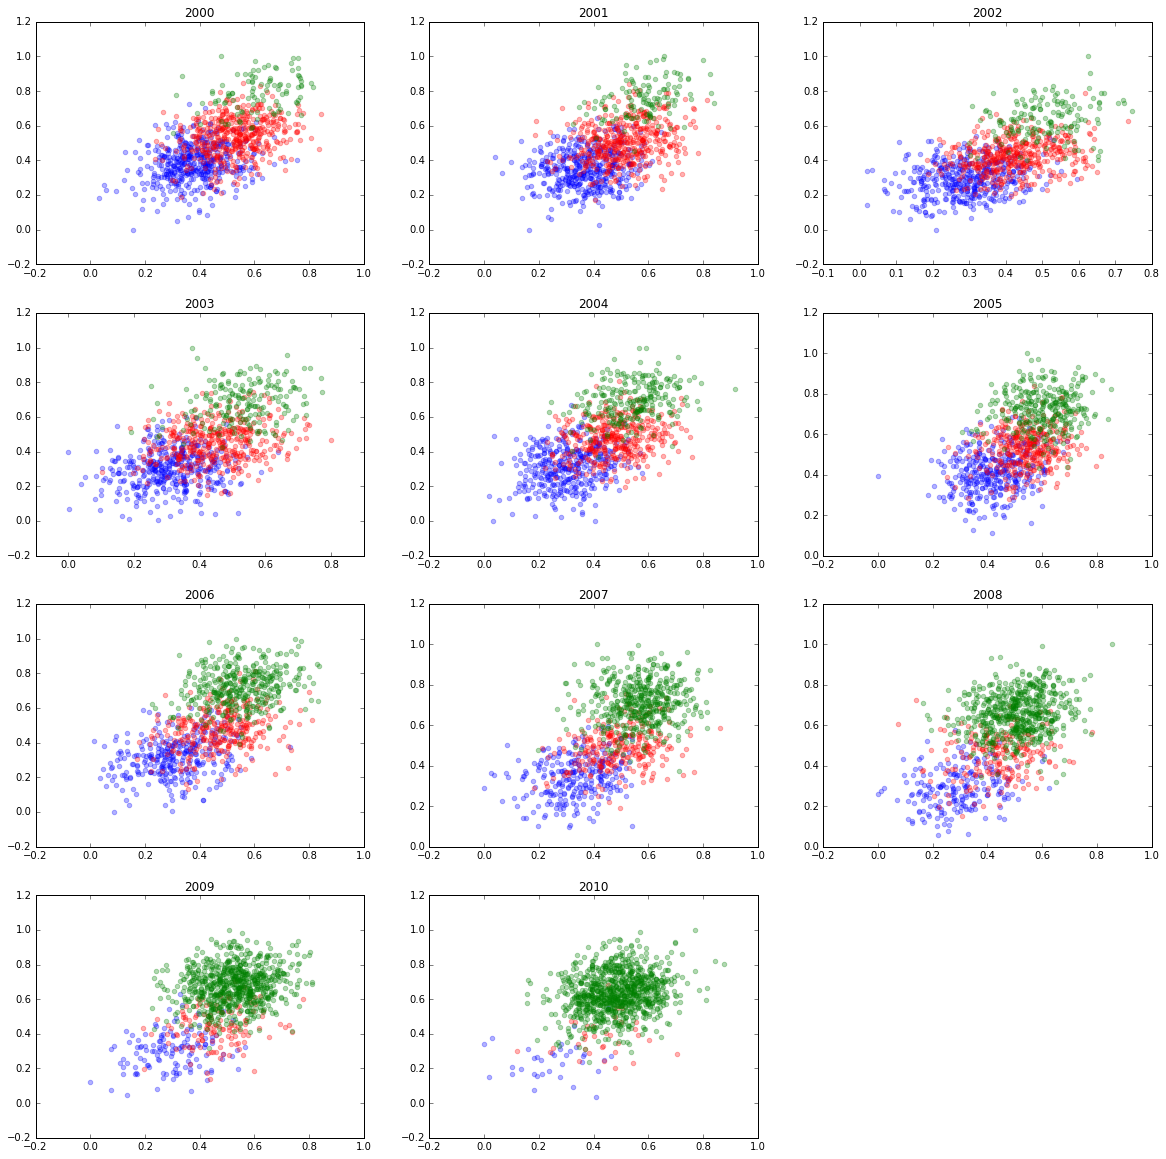

In [24]:
# Visualize:
# ----------

fig = plt.figure(figsize=(20 , 20))

for i , year in enumerate(range(2000 , 2011)):
    
    data = data_dic['data_raw_' + str(year)]
    
    x = data[:, :-1]
    y = data[:, -1 ]
    
    ax = fig.add_subplot(4 , 3, i + 1)
    ax.scatter(x[y == 0 , 0] , x[y == 0 , 1] , color  = 'b' , alpha = 0.3)
    ax.scatter(x[y == 1 , 0] , x[y == 1 , 1] , color  = 'r' , alpha = 0.3)
    ax.scatter(x[y == 2 , 0] , x[y == 2 , 1] , color  = 'g' , alpha = 0.3)
    ax.set_title (str(year))

plt.show()

**Discussion:**

 - Based on the visualization of the data, a multivariate distribution with constant variance across the classes seems to be a reasonable assumption as no substantial change in the scatter or the orientation of the data for the three classes across the different years

#### 2. Considering the year 2000:

<br>
The following will be performed:

 - Split the data into training and test for each class
 - Consider Logistic regression:
  - Using Cross validation estimate the best C
  - Fit test with the best C and visualize decission boundaries
 - Consider LDA:
  - Train on training set
  - Fit test and visualize decission boundaries
 - Compare between both methods:

**Spliting the data into training and test:**

<br>

In [25]:
# Split into training and test for year 2000 data:
# -----------------------------------------------

# split ratio
split_ratio = 0.5

# extract the data
data_all = data_dic['data_raw_2000']

# length of the data
length_2000 = data_all.shape[0]

''' 1.  Extract Data for first Class  '''

# extract the first class
data_0 = data_all[data_all[:,-1] == 0.0 , :]

# shuffle the indices and split
perm_0 = np.random.permutation(data_0.shape[0])
stop_0  = int(split_ratio * len(perm_0)) + 1

# split into train and test
train_0 = data_0[:stop_0]
test_0  = data_0[stop_0:]

''' 2.  Extract Data for second Class  '''

# extract the second class
data_1 = data_all[data_all[:,-1] == 1.0 , :]

# shuffle the indices and split
perm_1 = np.random.permutation(data_1.shape[0])
stop_1  = int(split_ratio * len(perm_1)) + 1

# split into train and test
train_1 = data_1[:stop_1]
test_1  = data_1[stop_1:]

''' 3.  Extract Data for third Class  '''

# extract the third class
data_2 = data_all[data_all[:,-1] == 2.0 , :]

# shuffle the indices and split
perm_2 = np.random.permutation(data_2.shape[0])
stop_2  = int(split_ratio * len(perm_2)) + 1

# split into train and test
train_2 = data_2[:stop_2]
test_2  = data_2[stop_2:]


''' 4. Combin all the test and train data  '''

# training data
train_first = np.concatenate((train_0 , train_1))
train_raw = np.concatenate((train_first , train_2))

# test data
test_first = np.concatenate((test_0 , test_1))
test_raw  = np.concatenate((test_first , test_2))

''' 5. Shuffle the training and test data'''

# train data
perm_train = np.random.permutation(train_raw.shape[0])
train = train_raw[perm_train]  

# test data
perm_test = np.random.permutation(test_raw.shape[0])
test = test_raw[perm_test]

# class sizes
len2000_0 = data_0.shape[0]
len2000_1 = data_1.shape[0]
len2000_2 = data_2.shape[0]

<br>

**Useful Functions:**

<br>

In [26]:
# function to calculate prior for class distribution:
# ---------------------------------------------------


def class_weights(population , changes):
    
    # initiate new weights
    new_weights = np.zeros(changes.shape)
    
    # initiate new population
    new_population = np.zeros(population.shape)
    
    # sum of original population
    total_pop = sum(population)
    
    # counters:
    zero_count = 0
    
    # sum for changes:
    sum_change = 0
    
    # modify the population according to change weights
    for i, pop in enumerate(population):
        
        # #xecute the number modification and track change
        if changes[i] != 0:
            new_population[i] = int(pop * changes[i]) 
            sum_change += new_population[i] - pop
        else :
            zero_count +=  1
        
    # split the difference
    delta_class = int(sum_change / zero_count)
    
    # modify the other classes
    for i , pop in enumerate(population):
        
        if new_population[i] == 0:
            new_population[i] = pop + delta_class
            
    # Insure the total number did not change:
    new_population[0] += total_pop - sum(new_population)
    
    # new weights
    for i in range(len(changes)):
        new_weights[i] = new_population[i] / total_pop
        
    return new_population , new_weights
            

<br>

**Considering Logistic Regression:**

<br>

In [27]:
# Construct an array of modified class population:
# ------------------------------------------------

# population array
population = np.array([len2000_0 , len2000_1 , len2000_2])

# length of the cross validation iterations
number_iter = 100

# array of weight change factors
change_factor = np.linspace(0.5 , 1.5 , number_iter)

# initiation of the population and weight arrays
pop_array = np.zeros((number_iter , 3))
pop_priors = np.zeros((number_iter , 3))
pop_weights = np.zeros((number_iter , 3))

# Filling the arrays
for i in range(number_iter):
    f = change_factor[i]
    pop_row , prior_row = class_weights(population , np.array([0.0 , 0.0 , f]))
    pop_array[i] = pop_row
    pop_priors[i] = prior_row
    pop_weights[i] = pop_row / population

In [28]:
# K-folds Cross Validation
# -----------------------

# number of folds
num_folds = 5.0

# training data
x_train = train[:,:-1]
y_train = train[:,-1]

# initiate folds
kf = KFold(x_train.shape[0] , n_folds = num_folds)


# Constrruct a C array
C_array = np.array(range(-6, 12 , 1))

# Intitate eror rate array
er_cv = np.zeros(C_array.shape)

# Fit for each weight row
for i , c in enumerate(C_array):

    
    # specify the priors
    log_reg = LogReg(C = 10**c)
    
    # Running sum for averaging
    test_sc = 0
    
    # Execute for each fold
    for ind_tr, ind_ts in kf:
        
        # Forming the train and test sets
        x_tr = x_train[ind_tr,:]
        y_tr = y_train[ind_tr]
        x_ts = x_train[ind_ts,:]
        y_ts = y_train[ind_ts]
        
        # Fit the model for the training sub-set
        log_reg.fit(x_tr, y_tr)
        
        # Calculate the test sub-set score and add it to the sum
        test_sc += log_reg.score(x_ts, y_ts)
        
    # Add the average to the R^2 array
    er_cv[i] = test_sc / num_folds

# Output
best_c = 10**C_array[np.argmax(er_cv)]
print '\n Best C value is :  ' ,best_c 
print '\n'


 Best C value is :   10000




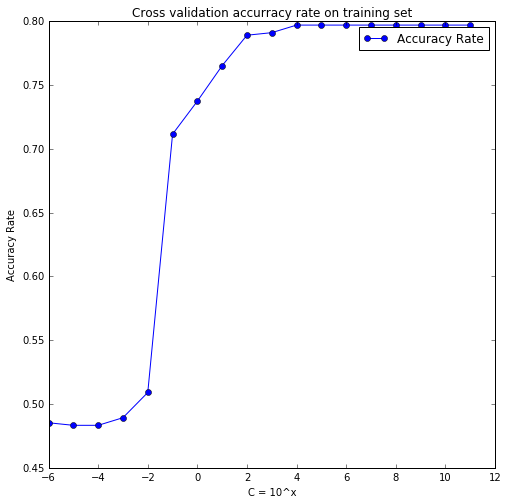

In [29]:
# visualize
# ---------

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(C_array , er_cv , 'bo-' , label = 'Accuracy Rate')
ax.set_title('Cross validation accurracy rate on training set')
ax.set_xlabel('C = 10^x') 
ax.set_ylabel('Accuracy Rate')
ax.legend(loc = 'best')

plt.show()

In [30]:
# Fit the test set:
# ----------------

# test data
x_test = test[:,:-1]
y_test = test[:,-1]

# Fitting model:
log_2000 = LogReg(C = best_c)

# Calculating prediction and accurracy rate
model_2000_lr = log_2000.fit(x_train , y_train)
y_2000_predict = model_2000_lr.predict(x_test)
acc_lr_2000 = model_2000_lr.score(x_test, y_test)
print '\n Accurracy Rate on test is :  ' , acc_lr_2000
print'\n'


 Accurracy Rate on test is :   0.774647887324




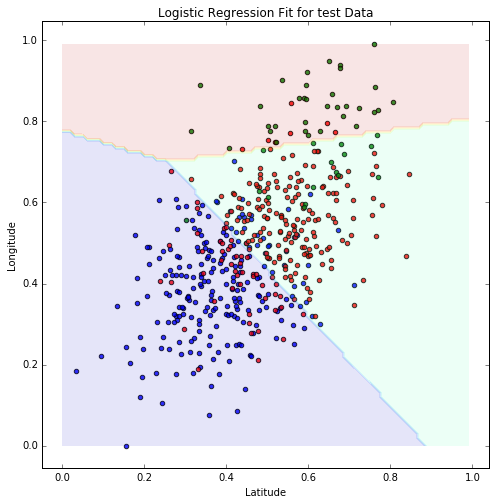

In [31]:
# Decission boundary:
# -------------------

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)
plot_decision_boundary(x_test, y_test, model_2000_lr, False, 'Logistic Regression Fit for test Data', ax)
plt.show()

<br>

**Considering LDA:**

<br>

In [32]:
# K-folds Cross Validation
# -----------------------

# number of folds
num_folds = 5

# training data
x_train = train[:,:-1]
y_train = train[:,-1]

# initiate folds
kf = KFold(x_train.shape[0] , n_folds = num_folds)


# Constrruct a C array
shrink_array = np.linspace(0.0 , 1.0 , 10)

# Intitate eror rate array
er_cv = np.zeros(shrink_array.shape)

# Fit for each weight row
for i , s in enumerate(shrink_array):

    
    # specify the priors
    lda = LDA(solver = 'lsqr' , shrinkage = s)
    
    # Running sum for averaging
    test_sc = 0
    
    # Execute for each fold
    for ind_tr, ind_ts in kf:
        
        # Forming the train and test sets
        x_tr = x_train[ind_tr,:]
        y_tr = y_train[ind_tr]
        x_ts = x_train[ind_ts,:]
        y_ts = y_train[ind_ts]
        
        # Fit the model for the training sub-set
        lda.fit(x_tr, y_tr)
        
        # Calculate the test sub-set score and add it to the sum
        test_sc += lda.score(x_ts, y_ts)
        
    # Add the average to the R^2 array
    er_cv[i] = test_sc / num_folds

# Output
best_shrinkage = shrink_array[np.argmax(er_cv)]
print '\n Best shrinkage value is :  ' , best_shrinkage
print '\n'


 Best shrinkage value is :   0.0




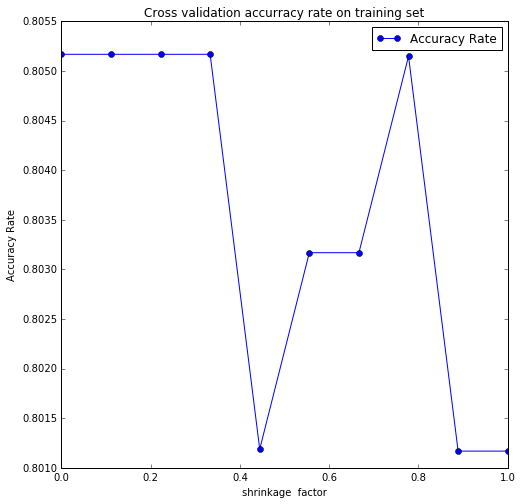

In [33]:
# visualize
# ---------

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(shrink_array , er_cv , 'bo-' , label = 'Accuracy Rate')
ax.set_title('Cross validation accurracy rate on training set')
ax.set_xlabel('shrinkage  factor') 
ax.set_ylabel('Accuracy Rate')
ax.legend(loc = 'best')

plt.show()

In [34]:
# Fit the test set:
# ----------------

# Fitting model:
lda_2000 = LDA(solver = 'lsqr' , shrinkage = best_shrinkage)

# Calculating prediction and accurracy rate
model_2000_lda = lda_2000.fit(x_train , y_train)

# prediction
y_2000_predict_lda = model_2000_lda.predict(x_test)

# Accurracy Rate
acc_lda_2000 = model_2000_lda.score(x_test, y_test)

#
print '\n Accurracy Rate on test is :  ' , acc_lda_2000
print'\n'


 Accurracy Rate on test is :   0.776659959759




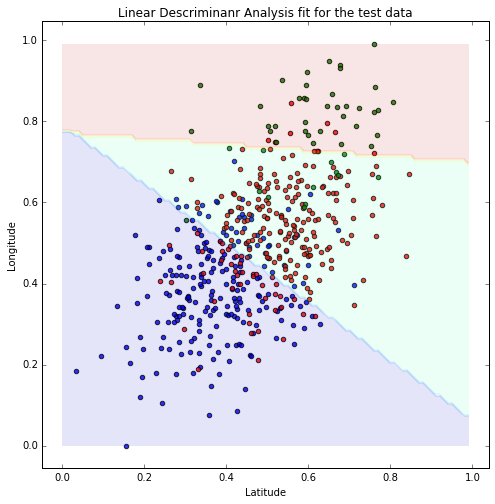

In [35]:
# Decission Boundaries:
# ---------------------

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)
plot_decision_boundary(x_test, y_test, model_2000_lda, False, 'Linear Descriminanr Analysis fit for the test data', ax)
plt.show()

**Comparison:**

Based on the data scatter, test accurracy and the decission boundary plot, it is obvious that the LDA is performing better. The data scatter being close to a multivariate normal distribution, support this suggestion

In [36]:
beta_0 = model_2000_lr.intercept_[0]
beta_1 = model_2000_lr.coef_[0]
x = test[:, :-1]
y = test[:,-1]
prob = np.zeros((test.shape[0] , ))
sum_fp = 0.0
sum_tp = 0.0
for i in range(len(prob)):
    expon = beta_1[0] * x[i,0] + beta_1[1] * x[i, 1] + beta_0
    ratio = m.exp(expon)
    probb = ratio / (1 + ratio)
    prob[i] = probb
    limit = 0.49998
    if probb > limit and y[i] !=0:
        sum_fp += 1
    elif probb >limit and y[i] == 0:
        sum_tp += 1

In [37]:
beta_0 = model_2000_lda.intercept_
beta_1 = model_2000_lda.coef_

x = test[:, :-1]
y = test[:,-1]

prob = np.zeros((test.shape[0] , 3))
pred_class = np.zeros((test.shape[0] , ))
ratio = np.zeros((8 , 2))

pop_0 = np.array(np.linspace(0.45, 0.1, 8)) 
pop_1 = np.array(np.linspace(0.45, 0.1, 8))
pop_2 = np.array(np.linspace(0.1,  0.8, 8))


for j in range(len(pop_0)):
    
    sum_fp = 0.0
    sum_tp = 0.0
    for i in range(len(prob)):
        prob[i, 0] = beta_1[0 , 0] * x[i,0] + beta_1[0, 1] * x[i, 1] + beta_0[0] + m.log(pop_0[j])
        prob[i , 1] = beta_1[1, 0] * x[i,0] + beta_1[1, 1] * x[i, 1] + beta_0[1] + m.log(pop_1[j])
        prob[i , 2] = beta_1[2, 0] * x[i,0] + beta_1[2, 1] * x[i, 1] + beta_0[2] + m.log(pop_2[j])
        pred_class[i] = np.argmax(prob[i])
        if pred_class[i] == y[i]:
            sum_tp  += 1
        else:
            sum_fp += 1
    ratio[j , 0] = sum_tp / len(test)
    ratio[j , 1] = sum_fp / len(test)

<br>

** 3. Apply for different years:**

<br>

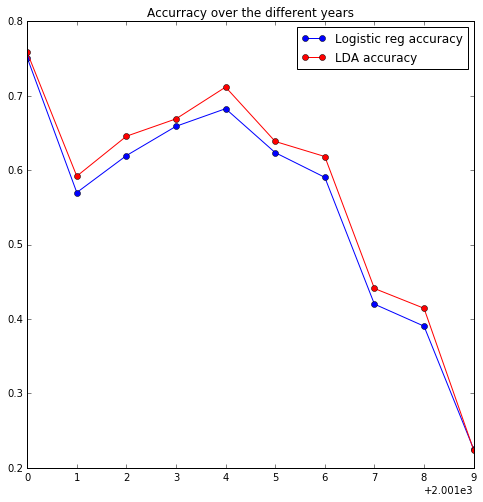


 Prediction deteriorates  accross the years 

 Logistic regression accuracy is lower than LDA 



In [38]:
# Evaluate the models for each year:
# ----------------------------------

# initiate score arrays
lr_score_array = np.zeros(10,)
lda_score_array = np.zeros(10,)

# Calculate score per year:
for i , year in enumerate(range(2001 , 2011)):
    
    # specify the year dara
    data = data_dic['data_raw_' + str(year)] 
    
    # extract features and response
    x = data[:,:-1]
    y = data[:,-1]
    
    # calculate scores
    score_lr = model_2000_lr.score(x , y)
    score_lda = model_2000_lda.score(x , y)
    
    # update the arrays
    lr_score_array[i] = score_lr
    lda_score_array[i] = score_lda
    
# visualize
xaxis = np.array(range(2001,2011)).reshape(lr_score_array.shape)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)
ax.plot(xaxis,lr_score_array , 'bo-' , label = "Logistic reg accuracy")
ax.plot(xaxis, lda_score_array, 'ro-' , label = 'LDA accuracy')
ax.set_title('Accurracy over the different years')
ax.legend(loc = 'best')

plt.show()

print '\n Prediction deteriorates  accross the years \n'
print ' Logistic regression accuracy is lower than LDA \n'

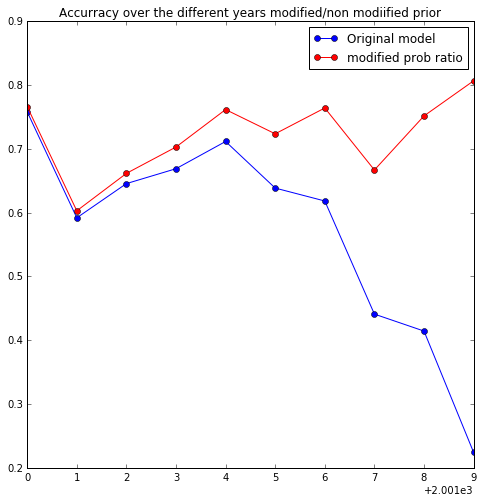


 Obvious improvment of the model performance over the years 



In [39]:
# Improving LDA performance:
# --------------------------

# model coefficients
beta_0 = model_2000_lda.intercept_
beta_1 = model_2000_lda.coef_

# initialize matrices
improved_score = np.zeros(10,)


for i ,year in enumerate(range(2001 , 2011)):
    
    # specify the year dara
    data = data_dic['data_raw_' + str(year)] 
    
    # extract features and response
    x = data[:,:-1]
    y = data[:,-1]

    ## priors modification
    # exponent
    n = i + 1
    
    # class modifier
    mod = 1.25 ** n
    
    # data dimensions
    pop_total = len(data)
    original_2 = len2000_2
    
    # new values
    new_2 = mod * original_2 / len2000_2
    new_0 = (pop_total - mod * original_2) / (2.0 * len2000_0 )
    new_1 = (pop_total - mod * original_2) / (2.0 * len2000_1)
    
    
    # initialize probability measure
    prob = np.zeros((data.shape[0] , 3))
    
    # initialize running sum
    score = np.zeros((data.shape[0] ,))
    
    pred_class = np.zeros((data.shape[0] , ))
    
    # Calculate model    
    for j in range(len(data)):
        prob[j, 0] = beta_1[0 , 0] * x[j,0] + beta_1[0, 1] * x[j, 1] + beta_0[0] + m.log(new_0)
        prob[j , 1] = beta_1[1, 0] * x[j,0] + beta_1[1, 1] * x[j, 1] + beta_0[1] + m.log(new_1)
        prob[j , 2] = beta_1[2 , 0] * x[j,0] + beta_1[2, 1] * x[j, 1] + beta_0[2] + m.log(new_2)
        pred_class[j] = np.argmax(prob[j])
        if pred_class[j] == y[j]:
            score[j] = 1
    
    # Calculate the improved score
    improved_score[i] = np.sum(score) / pop_total
    
# visualize
# ----------

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)
ax.plot(xaxis,lda_score_array , 'bo-' , label = "Original model")
ax.plot(xaxis, improved_score, 'ro-' , label = 'modified prob ratio')
ax.set_title('Accurracy over the different years modified/non modiified prior')
ax.legend(loc = 'best')

plt.show()

print '\n Obvious improvment of the model performance over the years \n'

### Part 2(b): Geographic patterns in urban demographics

In `dataset_2.txt` and `dataset_3.txt` you have the demographic information for a random sample of houses in two regions in Cambridge. There are only two economic brackets for the households in these datasets: 

0: low-income or middle-class, 

1 - high-income. 

For each region, recommend a classification model, chosen from all the ones you have learned, that is most appropriate for classifying the demographics of households in the region.

**Hint:** Support your answers with both numerical and visual analysis.

<font color = 'blue'>
### Solution:
</font>
<br>

#### 1. Open Data Sets and Visualize:

<br>

In [40]:
# Open datasets:
# -------------

# Construct raw arrays
data2_raw = np.loadtxt('datasets/dataset_2.txt' , delimiter = ' ')
data3_raw = np.loadtxt('datasets/dataset_3.txt' , delimiter = ' ')

# Split into features and response
x2 = data2_raw[:, :-1]
y2 = data2_raw[:,-1]

x3 = data3_raw[:, :-1]
y3 = data3_raw[:,-1]

# split by class
x2_0 = x2[y2 == 0]
x2_1 = x2[y2 == 1]

x3_0 = x3[y3 == 0]
x3_1 = x3[y3 == 1]

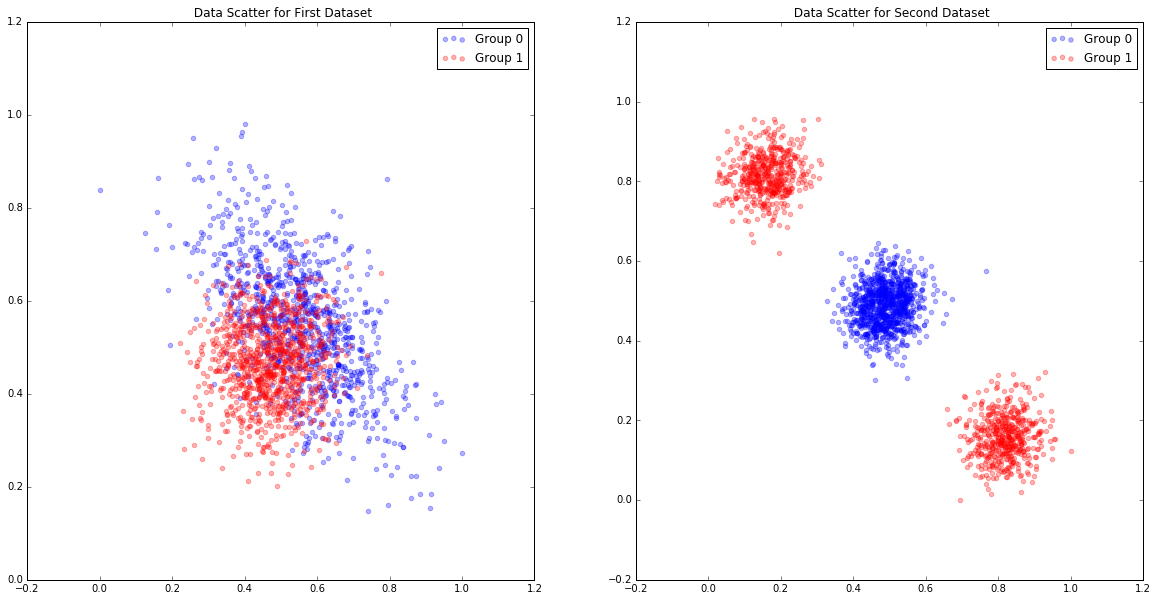

In [41]:
# Visualize:
# ----------

fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(1 , 2, 1)
ax1.scatter(x2_0[: , 0] , x2_0[: , 1] , color = 'b' , alpha = 0.3 , label = 'Group 0')
ax1.scatter(x2_1[: , 0] , x2_1[: , 1] , color = 'r' , alpha = 0.3 , label = 'Group 1')
ax1.set_title(' Data Scatter for First Dataset')
ax1.legend(loc = 'best')

ax2 = fig.add_subplot(1 , 2, 2)
ax2.scatter(x3_0[: , 0] , x3_0[: , 1] , color = 'b' , alpha = 0.3 , label = 'Group 0')
ax2.scatter(x3_1[: , 0] , x3_1[: , 1] , color = 'r' , alpha = 0.3 , label = 'Group 1')
ax2.set_title(' Data Scatter for Second Dataset')
ax2.legend(loc = 'best')

plt.show()

** Solution procedure:**

We will try logistic regression, LDA, QDA and KNN for both data sets and we will determine which model is performing better than the other and provide an explanation about the conclusion. For each dataset we will:

 - split into training and test
 - perform  cross validation to obtain best model parameters
 - Fit the test data set and calculate the accuracy rate
 
These steps will be repeated for each of the two datasets


<br>
** 1 . General Operations :**


<br>

In [52]:
# split into train and test for x:
# -------------------------------

def split_x(x , ratio):
    
    length = x.shape[0]
    perm = np.random.permutation(length)
    
    edge = int(ratio * length)
    
    x_train = x[:edge]
    x_test  = x[edge:]
    
    
    return x_train , x_test

In [58]:
# Split the data into train and test:
# -----------------------------------

# split the x
x2_0_train , x2_0_test = split_x(x2_0, 0.5)
x2_1_train , x2_1_test = split_x(x2_1, 0.5)

# y for zero
y2_0_train = np.zeros((x2_0_train.shape[0],))
y2_0_test  = np.zeros((x2_0_test.shape[0],))

# y for 1
y2_1_train = np.ones((x2_1_train.shape[0],))
y2_1_test  = np.ones((x2_1_test.shape[0],))

# x for train
x2_train = np.concatenate((x2_0_train , x2_1_train) , axis = 0)

# x for test
x2_test = np.concatenate((x2_0_test, x2_1_test) , axis = 0)

# y for train
y2_train = np.concatenate((y2_0_train , y2_1_train) , axis = 0)

# y for test
y2_test = np.concatenate((y2_0_test , y2_1_test) , axis = 0)

(1000L,)

In [54]:
# K-folds Cross Validation function:
# ---------------------------------

def models_cv (x_train , y_train):
    # number of folds
    num_folds = 5


    # initiate folds
    kf = KFold(x_train.shape[0] , n_folds = num_folds)

    # Constrruct parameters arrays
    C_array      = np.array(range(-11, 9))
    shrink_array = np.array(np.linspace(0.0, 1.0, 20))
    reg_array    = np.array(np.linspace(0.0, 1.0, 20))
    neighbors    = np.array(range(3,23))

    # Intitate eror rate array
    er_cv = np.zeros((C_array.shape[0], 4))

    # Fit for each parameter
    for i in range(20):
    
        # score array initiation
        score_array = np.zeros((num_folds , 4))
    
        #extract parameters
        C   = C_array[i]
        shr = shrink_array[i]
        reg = reg_array[i]
        nbr = neighbors[i]
     
        # specify the models
        log_reg = LogReg(C = 10**C)
        lda     = LDA(solver = 'lsqr' , shrinkage = shr)
        qda     = QDA(reg_param = reg)
        knn     = KNN(n_neighbors = nbr)

        # fold counter
        fold = 0
    
        # Execute for each fold
        for ind_tr, ind_ts in kf:
        
            # Forming the train and test sets
            x_tr = x_train[ind_tr,:]
            y_tr = y_train[ind_tr]
            x_ts = x_train[ind_ts,:]
            y_ts = y_train[ind_ts]
            
            # Fit the models for the training sub-set
            log_reg.fit(x_tr, y_tr)
            lda.fit(x_tr, y_tr)
            qda.fit(x_tr, y_tr)
            knn.fit(x_tr, y_tr)
            
            # Calculate the test sub-set score and add it to the sum
            score_array[fold, 0]  = log_reg.score(x_ts, y_ts)
            score_array[fold, 1]  =  lda.score(x_ts, y_ts)
            score_array[fold, 2]  =  qda.score(x_ts, y_ts)
            score_array[fold, 3]  =  knn.score(x_ts, y_ts)
            
            fold += 1
        
        # average scores and add to array  
        er_cv[i] = np.average(score_array , axis = 0)
        
        # best parameters arrays
        C_acc = er_cv[:,0]
        shrink_acc = er_cv[:,1]
        reg_acc = er_cv[:, 2]
        n_acc = er_cv[:,3]
        
        # bestparametrs
        best_C = C_array[np.argmax(C_acc)]
        best_shrink = shrink_array[np.argmax(shrink_acc)]
        best_reg = reg_array[np.argmax(reg_acc)]
        best_n  = neighbors[np.argmax(n_acc)]

        
    return np.array([10**best_C , best_shrink , best_reg , best_n]) , er_cv

<br>

** 2. Considering First Dataset: **


<br>

In [56]:
# Fitting the four models using the best parameters:
# -------------------------------------------------

# Parameters array
parameters , acc = models_cv(x2_train , y2_train)

# values:
c = parameters[0]
shrink_best = parameters[1]
reg_best = parameters[2]
neighbor = int(parameters[3])

## Models Evaluation

# model
lr_2 = LogReg(C = c)
lda_2 = LDA(solver = 'lsqr', shrinkage = shrink_best)
qda_2 = QDA(reg_param = reg_best)
knn_2 = KNN(n_neighbors = neighbor)

# fit
model_lr_2 = lr_2.fit(x2_train ,y2_train)
model_lda_2 = lda_2.fit(x2_train ,y2_train)
model_qda_2 = qda_2.fit(x2_train ,y2_train)
model_knn_2 = knn_2.fit(x2_train ,y2_train)

# predict
y_pred_lr_2 = model_lr_2.predict(x2_test)
y_pred_lda_2 = model_lda_2.predict(x2_test)
y_pred_qda_2 = model_qda_2.predict(x2_test)
y_pred_knn_2 = model_knn_2.predict(x2_test)

# Accurracy
score_lr2 = model_lr_2.score(x2_test , y2_test)
score_lda2 = model_lda_2.score(x2_test , y2_test)
score_qda2 = model_qda_2.score(x2_test , y2_test)
score_knn2 = model_knn_2.score(x2_test , y2_test)

# Output
print '\n The score for the test sets are as follows: \n'
print ' Logistic Regression             : ', score_lr2
print ' Linear Descriminant Analysis    : ', score_lda2
print ' Quadratic Descriminant Analysis : ', score_qda2
print ' K-Nearest Neighbor              : ', score_knn2
print ' \n'


 The score for the test sets are as follows: 

 Logistic Regression             :  0.75
 Linear Descriminant Analysis    :  0.753
 Quadratic Descriminant Analysis :  0.783
 K-Nearest Neighbor              :  0.785
 



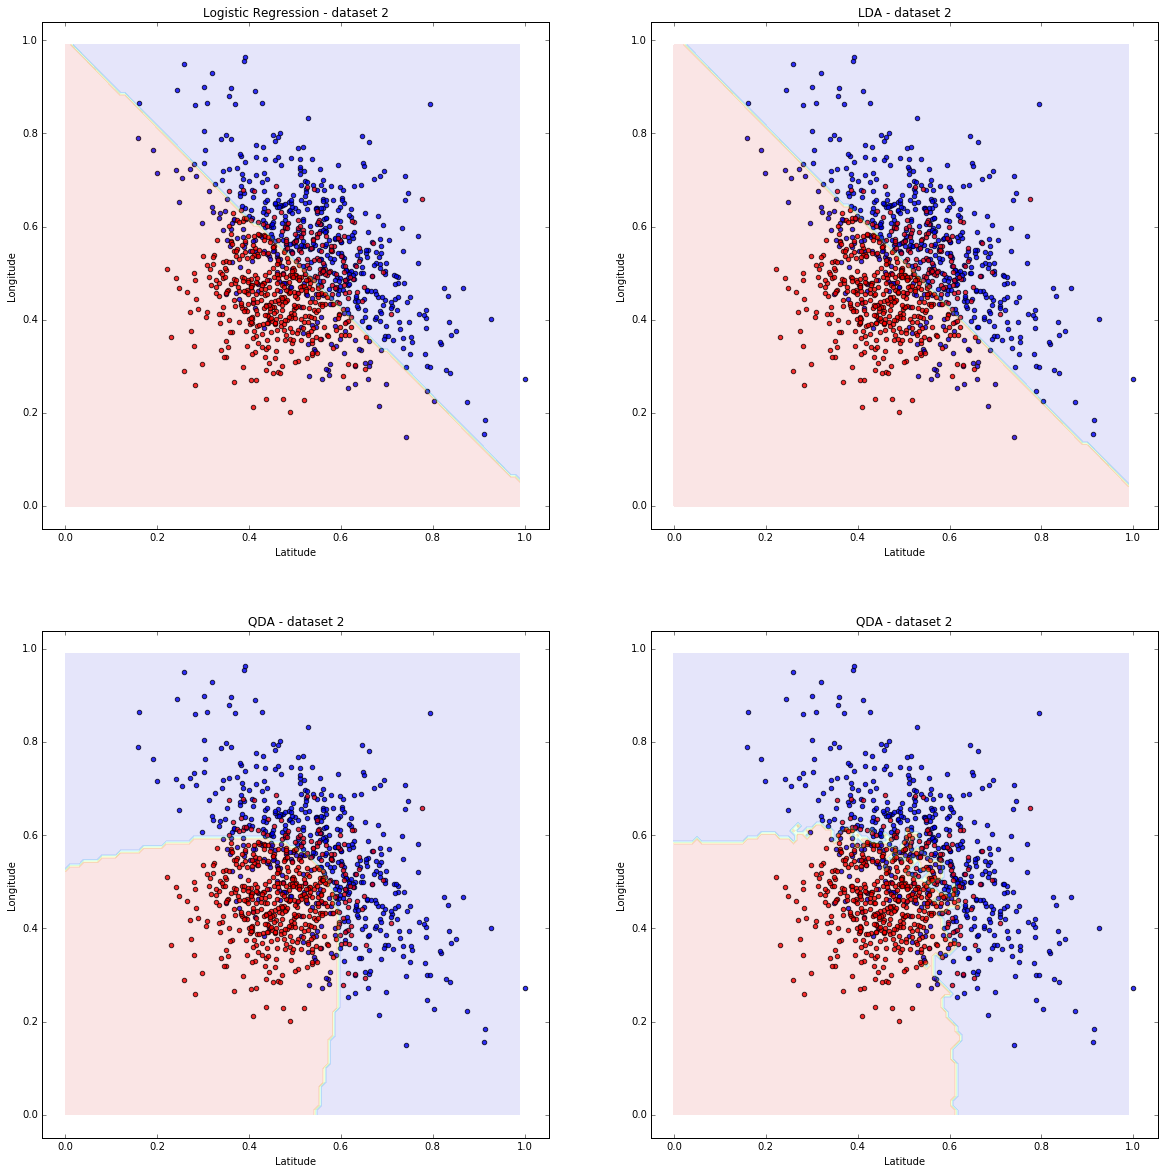

In [59]:
# Visualize Decision boundaries on test sets
# ------------------------------------------

# general initiation
fig = plt.figure(figsize = (20,20))

x = x2_test
y = y2_test

# Plot Logestic Regression
ax1 = fig.add_subplot(221)
plot_decision_boundary(x, y, model_lr_2, False, 'Logistic Regression - dataset 2', ax1)

# Plot LDA
ax2 = fig.add_subplot(222)
plot_decision_boundary(x, y, model_lda_2, False, 'LDA - dataset 2', ax2)

# Plot QDA
ax3 = fig.add_subplot(223)
plot_decision_boundary(x, y, model_qda_2, False, 'QDA - dataset 2', ax3)

# Plot k-NN
ax4 = fig.add_subplot(224)
plot_decision_boundary(x, y, model_knn_2, False, 'QDA - dataset 2', ax4)

plt.show()


<br>

** 2. Considering Second Dataset: **


<br>

In [ ]:
# Fitting the four models using the best parameters:
# -------------------------------------------------

# Parameters array
parameters , acc = models_cv(train_3)

# values:
c = parameters[0]
shrink_best = parameters[1]
reg_best = parameters[2]
neighbor = int(parameters[3])

## Models Evaluation

# model
lr_3 = LogReg(C = c)
lda_3 = LDA(solver = 'lsqr', shrinkage = shrink_best)
qda_3 = QDA(reg_param = reg_best)
knn_3 = KNN(n_neighbors = neighbor)

# fit
model_lr_3 = lr_3.fit(train_3[:, :-1] ,train_3[:, -1])
model_lda_3 = lda_3.fit(train_3[:, :-1] ,train_3[:, -1])
model_qda_3 = qda_3.fit(train_3[:, :-1] ,train_3[:, -1])
model_knn_3 = knn_3.fit(train_3[:, :-1] ,train_3[:, -1])

# predict
y_pred_lr_3 = model_lr_3.predict(test_3[:, :-1])
y_pred_lda_3 = model_lda_3.predict(test_3[:, :-1])
y_pred_qda_3 = model_qda_3.predict(test_3[:, :-1])
y_pred_knn_3 = model_knn_3.predict(test_3[:, :-1])

# Accurracy
score_lr3 = model_lr_3.score(test_3[:, :-1] , test_3[:, -1])
score_lda3 = model_lda_3.score(test_3[:, :-1] , test_3[:, -1])
score_qda3 = model_qda_3.score(test_3[:, :-1] , test_3[:, -1])
score_knn3 = model_knn_3.score(test_3[:, :-1] , test_3[:, -1])

# Output
print '\n The score for the test sets are as follows: \n'
print ' Logistic Regression             : ', score_lr3
print ' Linear Descriminant Analysis    : ', score_lda3
print ' Quadratic Descriminant Analysis : ', score_qda3
print ' K-Nearest Neighbor              : ', score_knn3
print ' \n'

In [ ]:
# Visualize Decision boundaries on test sets
# ------------------------------------------

# general initiation
fig = plt.figure(figsize = (20,20))
x = test_3[:, :-1]
y = test_3[:, -1]

# Plot Logestic Regression
ax1 = fig.add_subplot(221)
plot_decision_boundary(x, y, model_lr_3, False, 'Logistic Regression - dataset 2', ax1)

# Plot LDA
ax2 = fig.add_subplot(222)
plot_decision_boundary(x, y, model_lda_3, False, 'LDA - dataset 2', ax2)

# Plot QDA
ax3 = fig.add_subplot(223)
plot_decision_boundary(x, y, model_qda_3, False, 'QDA - dataset 2', ax3)

# Plot k-NN
ax4 = fig.add_subplot(224)
plot_decision_boundary(x, y, model_knn_3, False, 'QDA - dataset 2', ax4)


plt.show()

---

## Challenge Problem: Regularization

We have seen ways to include different forms of regularizations in Linear regression and Logistic regression, in order to avoid overfitting. We will now explore ways to incorporate regularization within the discriminant analysis framework.

- When we have a small training sample, we end up with poor estimates of the class proportions $\pi_i$ and covariance matrices $\Sigma$. How can we regularize these quantities to improve the quality of the fitted model?


- We have seen that different assumptions on the covariance matrix results in either a linear or quadratic decision boundary. While the former may yield poor prediction accuracy, the latter could lead to over-fitting. Can you think of a suitable way to regularize the covariance to have an intermediate fit?

The solutions that you suggest must include a parameter that allows us to control the amount of regularization.

Be detailed in your explanation and support your reasoning fully. You do not, however, need to implement any of these solutions.